# Modélisation

$$-\frac{\mu}{2} \mathcal{H}[\delta'] - \eta \dot \delta + \dot \tau_b t= f \sigma$$
$$f = f_0 + a \ln \frac{\dot \delta}{v_0} + b \ln \frac{\theta v_0}{d_c}$$

On dérive par rapport au temps sachant que : $\frac{\partial}{\partial t}\mathcal{H}[\delta'] = \mathcal{H}[\frac{\partial}{\partial t}\delta'] = \mathcal{H}[\frac{\partial^2 \delta}{\partial t \partial x}] = \mathcal{H}[\frac{\partial^2 \delta}{\partial x \partial t}] = \mathcal{H}[\frac{\partial v}{\partial x}] = \mathcal{H}[v']$

On trouve : $$-\frac{\mu}{2} \mathcal{H}[v'] - \eta \dot v + \dot \tau_b= \sigma (a \frac{\dot v}{v} + b \frac{\dot \theta}{\theta})$$

On substitue $\dot \theta$ par son expression donnée par la loi de vieillisement.

Finalement :
$$\boxed{\left \{ \begin{array}{rcl}
\dot v &=& \frac {v}{\sigma a + \eta v} \big( v \frac{b \sigma}{d_c} - \frac{b \sigma}{\theta} - \frac{\mu}{2}\mathcal{H}[v'] + \dot \tau_b \big) \\
\dot \theta &=& 1 - \frac{v \theta}{d_c}
\end{array}
\right.}$$

On pose pour l'adimensionement : $$\bar t = \frac{t v_0}{d_c} \\
\bar x = \frac{x}{L_b} \\
L_b = \frac{\mu d_c}{b \sigma} \\
\bar v = \frac{v}{v_0} \\
\bar \theta = \frac{\theta v_0}{d_c}$$

On effectue le changement de variable suivant : $$\varphi = \ln \bar v$$
$$ \nu = \ln \bar \theta$$

On pose également par comodité les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\dot{\bar{\tau_b}} = \frac{d_c}{b \sigma v_0} \frac{\partial \tau_b}{\partial t} = \frac{1}{b \sigma} \frac{\partial \tau_b}{\partial \bar t}$$

On en déduit :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

# Schéma numérique

On effectue un maillage de l'espace et du temps, on notera en exposant $n$ pour représenter la date $t_n$ et on noter $i$ en indice pour représenter l'abscisse $x_i$.

On discrétise l'espace et le temps de la manière suivante :
$$\left \{ \begin{array}{rcl}
t_n = n \cdot \Delta t \\
x_i = i \cdot \Delta x
\end{array}
\right.$$

Le pas de temps $\Delta t$ sera amené à évoluer pendant la résolution, mais le pas d'espace $\Delta x$ est constant dans toute l'implémentation.

On peut alors poser $\varphi^n_i$ la vitesse à la date $t_n$ et à l'abscisse $x_i$, et $\nu_n^i$ la variable à la date $t_n$ et à l'abscisse $x_i$.

On a alors un schéma numérique couplé de la forme :

$$\boxed{\left \{ \begin{array}{rcl}
\dot \varphi_i^n &=& f (\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu _i^n)  \\
\dot \nu_i^n &=& g(\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu_i^n)
\end{array}
\right.}$$


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [54]:
#Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-3
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

alpha = a/b #=0.2
beta = eta*v0/(b*sigma) #=6e-08
taubbardot = dc*taubdot/(b*sigma*v0) #=0.1

deltaX = int(Lb/4) #=75
#deltaX < Lb
#L > Lb
N = 100
I = 32
L = I * deltaX

In [55]:
#Calcul du gradient de la transformée de Hilbert (cf. doc)

def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    F=np.fft.fft(f)
    k=np.fft.fftfreq(len(f),deltaX)

    F=np.abs(k*2*np.pi)*F

    hh=np.fft.ifft(F)
    return hh.real

In [56]:
#Résolution numérique de l'équation différentielle (cf. doc)

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        #print('ykk='+str(ykk))
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        tf = time.time()
        K = K +1
        if erreur < tol:
            print(tf-t0)
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            print(tf-t0)
            return ykk, h
        h = s*h
        print(tf-t0)
    return ykk, h

On pose pour la résolution numérique le vecteur $y^k$ qui contient le valeurs de $\varphi$ et de $\nu$ à la date $k$ et en tous le points de l'espace:

$$y^k = \left( \begin{array}{rcl}\varphi^k \\ \nu^k \end{array} \right) = \left( \begin{array}{rcl}(\varphi_0^k, \ldots, \varphi_I^k) \\ (\nu_0^k, \ldots, \nu_I^k) \end{array} \right)$$

Le système différentiel s'écrit alors :

$$\dot y^k = \left( \begin{array}{rcl} \dot \varphi^k \\ \dot \nu^k \end{array} \right) = \left( \begin{array}{ccc}  \frac {1}{\alpha + \beta e^{\varphi^k}} \big( e^{\varphi^k}-e^{-\nu^k} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi^k}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\ e^{-\nu^k} - e^{\varphi^k} \end{array} \right) = F(y^k)$$

In [57]:
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    H = hilbert_grad(v, deltaX)
    return (v - 1/theta - 1/2*H + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    F1 = phidot(phi, nu)
    F2 = nudot(phi, nu)
    plt.plot(x, F1)
    return np.array([F1, F2])

Dans notre cas, la résolution se fait par récurrence avec le schéma suivant :
$$y^{k+1} = RKF(F, y^k)$$

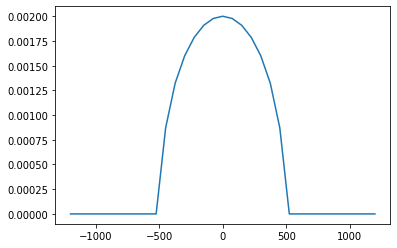

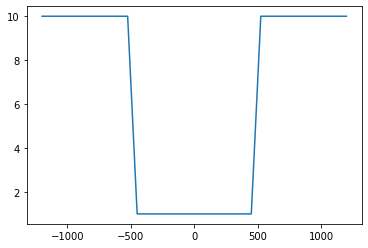

In [58]:
#Conditions initiales

x = np.arange(-L//2, L//2 + 1, deltaX)
d = 500 #largeur de la zone de glissemnt initiale

A = []
for y in x :
    if y < d and y > -d:
        A.append(np.sqrt(d**2 - y**2)/(d**2))
    else :
        A.append(v0)
        
B = []
for y in x :
    if y < d and y > -d:
        B.append((d**2 - np.sqrt(d**2 - y**2))/(d**2))
    else :
        B.append(10)
        
A = np.array(A)
B = np.array(B)
h = 1e-2

plt.plot(x, A)
plt.show()
plt.plot(x, B)
plt.show()

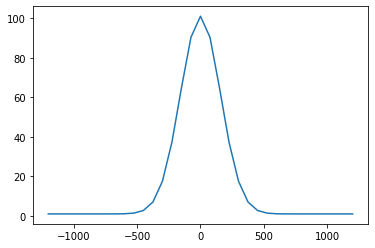

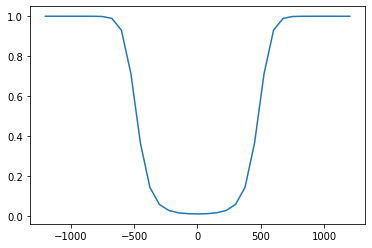

In [59]:
C = np.exp(-x**2/(d**2/5))*100 + np.ones(I+1)
plt.plot(x,C)
plt.show()

D = 1/C
plt.plot(x,D)
plt.show()

0
0.02792835235595703
0.03793668746948242
0.043883562088012695
0.0568540096282959
0.07284426689147949
0.08078408241271973
0.08978438377380371
0.10376620292663574
0.10970854759216309
0.11571955680847168
0.12865757942199707
0.13866066932678223
0.14564299583435059
0.1515965461730957
0.16458868980407715
0.17256999015808105
0.17855429649353027
0.1845240592956543
0.19750046730041504
0.2044541835784912
0.21343088150024414
0.22795414924621582
0.23700666427612305
0.24405169486999512
0.2599654197692871
0.2679424285888672
0.27396392822265625
0.2799108028411865
0.294872522354126
0.30288028717041016
0.005953550338745117
0.011967897415161133
0.027965545654296875
0.035971879959106445
0.04195427894592285
0.049901485443115234
0.06187319755554199
0.06885123252868652
0.07586193084716797
0.08480978012084961
0.09581160545349121
0.10779452323913574
0.1267399787902832
0.13471770286560059
0.1516726016998291
0.1626744270324707
0.16965579986572266
0.18259263038635254
0.19256329536437988
0.19858312606811523
0.20

0.39490485191345215
0.4878818988800049
0.5836241245269775
0.683356523513794
0.7920651435852051
0.8409337997436523
0.8738455772399902
0.9227471351623535
0.9516808986663818
0.9646472930908203
0.9915752410888672
1.035485029220581
1.1321930885314941
1.2340316772460938
1.3285303115844727
1.428389549255371
1.5305039882659912
1.625248670578003
1.6482858657836914
1.6802000999450684
1.7121155261993408
1.7530381679534912
1.7779419422149658
1.799880027770996
1.8357861042022705
0.017000436782836914
0.04391288757324219
0.05884718894958496
0.08679795265197754
0.11369466781616211
0.1436154842376709
0.1735365390777588
0.20348596572875977
0.2513270378112793
0.3500661849975586
0.45379042625427246
0.5548193454742432
0.6619369983673096
0.7596828937530518
0.8621909618377686
0.8931074142456055
0.9270169734954834
0.9709146022796631
1.0157792568206787
1.0467290878295898
1.0756537914276123
1.0985915660858154
1.1245629787445068
1.1445047855377197
1.1714370250701904
1.2591006755828857
1.354215145111084
1.4673693

2.056857109069824
2.1356234550476074
2.294132709503174
2.4367451667785645
2.610339641571045
2.7644193172454834
2.8332278728485107
2.9090287685394287
2.970871925354004
3.0137457847595215
3.1158905029296875
0.15543675422668457
0.33446264266967773
0.5027425289154053
0.5925021171569824
0.657822847366333
0.7056937217712402
0.7590968608856201
0.8059430122375488
0.959143877029419
1.1188035011291504
1.3051064014434814
1.4684441089630127
1.520334005355835
1.602118730545044
1.655013084411621
1.7018208503723145
1.760695219039917
1.8706696033477783
2.026057004928589
2.2004475593566895
2.3691017627716064
2.546612501144409
2.6253256797790527
2.687591075897217
2.7404823303222656
2.8028244972229004
2.860663890838623
2.9623770713806152
3.1269571781158447
3.298344612121582
30
0.15224647521972656
0.3171119689941406
0.46086621284484863
0.523698091506958
0.588524580001831
0.6444075107574463
0.7052130699157715
0.8618009090423584
1.0313425064086914
1.2021539211273193
1.3795955181121826
1.4578471183776855
1.5

0.814572811126709
0.12023115158081055
0.07679247856140137
0.11149764060974121
0.08976030349731445
0.08176755905151367
0.08496642112731934
50
0.08121132850646973
0.07631349563598633
0.09126043319702148
0.10494327545166016
0.07800006866455078
0.10973691940307617
0.14060163497924805
0.21609997749328613
0.21654915809631348
0.11968016624450684
60
0.08876347541809082
0.11167240142822266
0.20647382736206055
0.24048376083374023
0.20766043663024902
0.09574174880981445
0.0831449031829834
0.1725144386291504
0.24317622184753418
0.24507808685302734
70
0.18902897834777832
0.09773850440979004
0.06781864166259766
0.07978701591491699
0.19594025611877441
0.23887944221496582
0.21743988990783691
0.17563104629516602
0.09523725509643555
0.06978130340576172
80
0.10372614860534668
0.22932124137878418
0.24111080169677734
0.23811626434326172
0.10903620719909668
0.07879900932312012
0.1076805591583252
0.17437243461608887
0.7876222133636475
0.08773517608642578
90
0.07483053207397461
0.08975911140441895
0.078791379

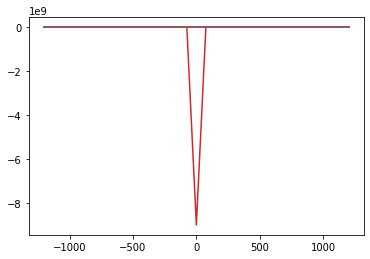

In [60]:
phik = np.log(C)
nuk = np.log(D)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    if n%10 == 0:
        print(n)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    Phi.append(yk[0])
    Nu.append(yk[1])

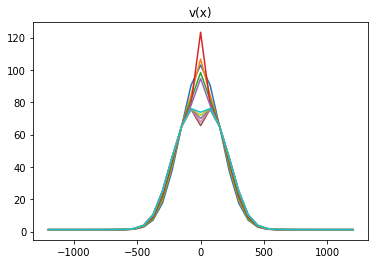

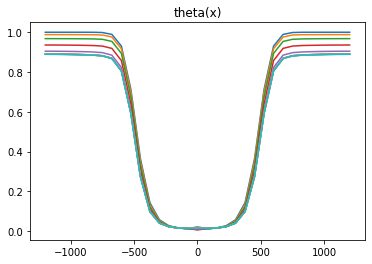

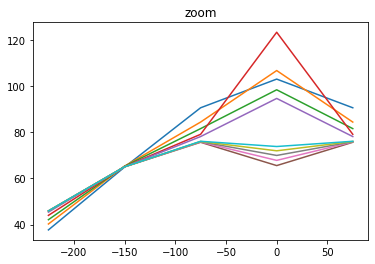

In [61]:
#Affichage

for n in range(1, N, 10):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')
plt.show()

for n in range(1, N, 10):
    plt.plot(x, np.exp(Nu[n]))
plt.title('theta(x)')
plt.show()

for n in range(1, N, 10):
    plt.plot(x[13:18], np.exp(Phi[n])[13:18])
plt.title('zoom')
plt.show()

In [62]:
V = np.exp(Phi)
Theta = np.exp(Nu)

M_V = max(V[0])
reduc = 0.5
V_indice = [0]
for k in range(len(V)):
    m = max(V[k])
    if m > M_V/reduc:
        V_indice.append(k)
        M_V = m

M_T = max(Theta[0])
T_indice = [0]
for k in range(len(Theta)):
    m = max(Theta[k])
    if m < M_T*reduc:
        T_indice.append(k)
        M_T = m

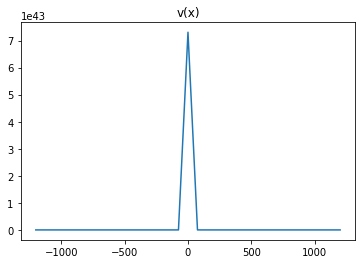

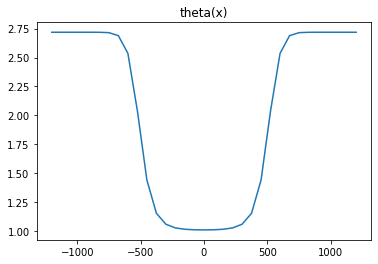

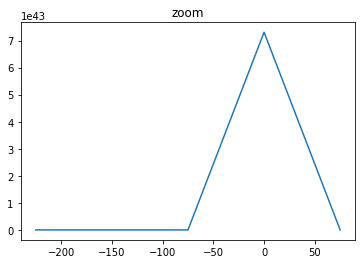

In [50]:
#Affichage

for n in V_indice:
    plt.plot(x, np.exp(V[n]))
plt.title('v(x)')
plt.show()

for n in T_indice:
    plt.plot(x, np.exp(Theta[n]))
plt.title('theta(x)')
plt.show()

for n in V_indice:
    plt.plot(x[13:18], np.exp(V[n])[13:18])
plt.title('zoom')
plt.show()

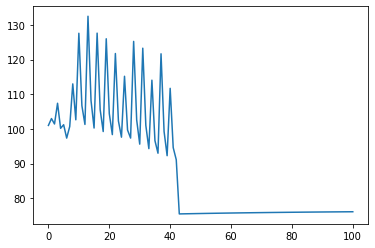

In [63]:
ma = [max(ligne) for ligne in V]
plt.plot(range(len(V)), ma)
plt.show()

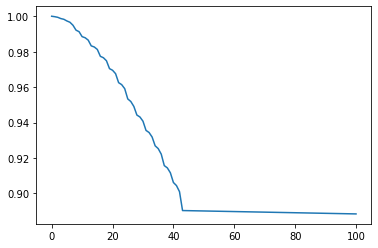

In [64]:
maT = [max(ligne) for ligne in Theta]
plt.plot(range(len(Theta)), maT)
plt.show()